In [1]:
import numpy as np

In [2]:
import pandas as pd 
import anndata as ad
import scanpy as sc

In [3]:
import screenpro as scp

In [4]:
import matplotlib.pyplot as plt

In [5]:
sc.settings.set_figure_params(dpi=150, frameon=False, figsize=(3, 3), color_map='RdGy', facecolor='white')

### 

    Total doubling:
    
    Vehicle		5.20
    NAC		5.56
    differences	-0.36

In [6]:
meta = pd.read_excel('sample list.xlsx',index_col=0)
meta = pd.DataFrame(meta.reset_index()['Sample'].str.split(' |_').str[1:].to_list(),columns=['condition','replicate'],index=meta.Label.to_list())
meta.replicate = meta.replicate.str[-1].astype(int)

In [7]:
counts = pd.read_csv('NAC_counts.txt',sep='\t',index_col=0)

In [8]:
# pd.read_excel('NAC_screenmeasurements.xlsx',index_col=0,header=[0,1])

In [9]:
# library = pd.read_csv('CRISPRiV3_library_1_2_unbalanced.csv',index_col=0).set_index('sgID_AB')

target_df = counts[['target']].copy()
target_df['targetType'] = counts.target.apply(lambda x: "negCtrl" if x == "non-targeting" else "targeting")
target_df = target_df.sort_values('target').sort_values('targetType',ascending=False)
target_df.targetType = pd.Categorical(target_df.targetType,categories=['targeting','negCtrl'])

In [10]:
adata = ad.AnnData(
    X   = counts.loc[target_df.index,meta.index].T.astype(int),
    obs = meta,
    var = target_df
)

screen = scp.ScreenPro(adata)

In [11]:
adata.to_df().sum(axis=0).eq(0).sum()

0

In [12]:
screen.n_reps

3

In [13]:
help(screen.calculateDrugScreen)

Help on method calculateDrugScreen in module screenpro:

calculateDrugScreen(t0, untreated, treated, db_untreated, db_treated, score_level) method of screenpro.ScreenPro instance
    Calculate gamma, rho, and tau phenotype scores for a drug screen dataset in a given `score_level`
    see this issue for discussion https://github.com/abearab/ScreenPro2/issues/15.
    Args:
        t0 (str): name of the untreated condition
        untreated (str): name of the untreated condition
        treated (str): name of the treated condition
        db_untreated (float): doubling rate of the untreated condition
        db_treated (float): doubling rate of the treated condition
        score_level (str): name of the score level



In [14]:
screen.adata.obs

,condition,replicate
TO_1_S1,T0,1
TO_2_S2,T0,2
TO_3_S3,T0,3
TO_4_S4,vehicle,1
TO_5_S5,vehicle,2
TO_6_S6,vehicle,3
TO_7_S7,NAC,1
TO_8_S8,NAC,2
TO_9_S9,NAC,3


In [15]:
screen.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='NAC', 
    db_untreated = 5.20,
    db_treated = 5.56,
    score_level='compare_reps'
)

	vehicle vs T0
	NAC vs T0
	NAC vs vehicle


### 

___
    
    Thu Nov 16 11:29:49 PST 2023
    
Tom 
> Are you able to extract phenotype scores from each screen replicate independently? The excel tables you provide are obviously an average of all replicates but I'd like to be able to plot bar graphs of phenotype scores for some genes that includes all three replicates to show the variability/error bars


In [16]:
help(scp.phenoScore.getPhenotypeScore)

Help on function getPhenotypeScore in module screenpro.phenoScore:

getPhenotypeScore(x, y, x_ctrl, y_ctrl, growth_rate, math, ave)
    Calculate phenotype score normalized by negative control and growth rate.
    Args:
        x (np.array): array of values
        y (np.array): array of values
        x_ctrl (np.array): array of values
        y_ctrl (np.array): array of values
        growth_rate (int): growth rate
        math (str): math to use for calculating score
        ave (str): average method
    Returns:
        np.array: array of scores



In [17]:
def get_replicate_score(screen,x_label, y_label):
    adata_ctrl = screen.adata[:,screen.adata.var.targetType.eq('negCtrl')].copy()

    results = {}
    
    for replicate in screen.adata.obs.replicate.unique():

        res = scp.phenoScore.getPhenotypeScore(
            x = screen.adata[screen.adata.obs.query(f'condition == "{x_label}" & replicate == {replicate}').index].X,
            y = screen.adata[screen.adata.obs.query(f'condition == "{y_label}" & replicate == {replicate}').index].X,

            x_ctrl = adata_ctrl[adata_ctrl.obs.query(f'condition == "{x_label}" & replicate == {replicate}').index].X,
            y_ctrl = adata_ctrl[adata_ctrl.obs.query(f'condition == "{y_label}" & replicate == {replicate}').index].X,

            growth_rate=1,
            math = screen.math,
            ave = 'row'
        )
        
        results.update({f'replicate_{replicate}':res})
    
    
    out = pd.DataFrame(
        results,
        index = screen.adata.var.index
    )
    return out

In [18]:
res = pd.concat({
    '':screen.adata.var.target,
    'gamma':get_replicate_score(screen,'T0', 'vehicle'),
    'tau':get_replicate_score(screen,'T0', 'NAC'),
    'rho':get_replicate_score(screen,'vehicle', 'NAC')
},axis=1)

In [19]:
res

gamma  \
                                                           target replicate_1   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1++A1...           A1BG    0.258055   
PPP1R13L_+_45908182.23-P1|PPP1R13L_-_45908257.2...       PPP1R13L   -3.484081   
PPP1R16A_+_145703395.23-P1P2|PPP1R16A_-_1457034...       PPP1R16A    0.274171   
PPP1R15B_-_204380704.23-P1P2|PPP1R15B_-_2043807...       PPP1R15B   -1.063440   
PPP1R15A_+_49375730.23-P1P2|PPP1R15A_+_49375905...       PPP1R15A   -0.039895   
...                                                           ...         ...   
non-targeting_02198|non-targeting_00658++non-ta...  non-targeting    0.029738   
non-targeting_02034|non-targeting_02136++non-ta...  non-targeting    0.099949   
non-targeting_01047|non-targeting_00258++non-ta...  non-targeting    0.369060   
non-targeting_02314|non-targeting_02526++non-ta...  non-targeting   -0.153833   
non-targeting_02243|non-targeting_00182++non-ta...  non-targeting   -0.405802   

                                                                            \
                                                   replicate_2 replicate_3   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1++A1...   -0.022664    0.373336   
PPP1R13L_+_45908182.23-P1|PPP1R13L_-_45908257.2...   -3.807186   -2.789717   
PPP1R16A_+_145703395.23-P1P2|PPP1R16A_-_1457034...   -0.379038    0.128052   
PPP1R15B_-_204380704.23-P1P2|PPP1R15B_-_2043807...   -1.005375   -1.015243   
PPP1R15A_+_49375730.23-P1P2|PPP1R15A_+_49375905...   -0.363402   -0.116610   
...                                                        ...         ...   
non-targeting_02198|non-targeting_00658++non-ta...    0.037418    0.381349   
non-targeting_02034|non-targeting_02136++non-ta...   -0.573920    0.107453   
non-targeting_01047|non-targeting_00258++non-ta...    0.002213    0.451502   
non-targeting_02314|non-targeting_02526++non-ta...    0.290145   -0.135999   
non-targeting_02243|non-targeting_00182++non-ta...   -0.445900   -0.058868   

                                                           tau              \
                                                   replicate_1 replicate_2   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1++A1...    0.389207    0.124518   
PPP1R13L_+_45908182.23-P1|PPP1R13L_-_45908257.2...   -4.217526   -3.012962   
PPP1R16A_+_145703395.23-P1P2|PPP1R16A_-_1457034...    0.311826    0.091212   
PPP1R15B_-_204380704.23-P1P2|PPP1R15B_-_2043807...   -1.849484   -1.752231   
PPP1R15A_+_49375730.23-P1P2|PPP1R15A_+_49375905...    0.207512   -0.594830   
...                                                        ...         ...   
non-targeting_02198|non-targeting_00658++non-ta...   -0.279076    0.302638   
non-targeting_02034|non-targeting_02136++non-ta...    0.435147   -0.055481   
non-targeting_01047|non-targeting_00258++non-ta...    0.056890   -0.143450   
non-targeting_02314|non-targeting_02526++non-ta...   -0.162599    0.361548   
non-targeting_02243|non-targeting_00182++non-ta...   -0.137330    0.150638   

                                                                       rho  \
                                                   replicate_3 replicate_1   
A1BG_+_58858964.23-P1|A1BG_-_58858788.23-P1++A1...    0.405016    0.115976   
PPP1R13L_+_45908182.23-P1|PPP1R13L_-_45908257.2...   -4.494219   -0.748621   
PPP1R16A_+_145703395.23-P1P2|PPP1R16A_-_1457034...    0.332234    0.022480   
PPP1R15B_-_204380704.23-P1P2|PPP1R15B_-_2043807...   -1.701833   -0.801219   
PPP1R15A_+_49375730.23-P1P2|PPP1R15A_+_49375905...   -0.005245    0.232231   
...                                                        ...         ...   
non-targeting_02198|non-targeting_00658++non-ta...    0.097100   -0.323989   
non-targeting_02034|non-targeting_02136++non-ta...   -0.107963    0.320022   
non-targeting_01047|non-targeting_00258++non-ta...    0.648244   -0.327345   
non-targeting_02314|non-targeting_02526++non-ta...   -0.017507   -0.023942   
non-targeting_02243|non-targeting_00182++non-ta...  

In [20]:
res.to_excel('NAC_replicate_phenotype_scores.xlsx')

In [21]:
screen.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='NAC', 
    db_untreated = 5.20,
    db_treated = 5.56,    
    # growth_rate=5.406447, 
    score_level='compare_reps'
)

	vehicle vs T0
	NAC vs T0
	NAC vs vehicle


In [22]:
screen.phenotypes['compare_reps'].to_excel('NAC_screen_results.xlsx')

## Plots

In [23]:
# screen.phenotypes['compare_reps']['tau:NAC_vs_T0']

In [24]:
almost_black = '#111111'

dark2 = ['#1b9e77',
         '#d95f02',
         '#7570b3',
         '#e7298a',
         '#66a61e',
         '#e6ab02',
         '#a6761d',
         '#666666']

### replicate scatter plots

In [25]:
def draw_scatter(adata, x, y, title, ax):
    bdata = adata[[x, y],:].copy()
    
    bdata.obs.index = [f'Replicate {str(r)}' for r in bdata.obs.replicate.to_list()]
    x_lab, y_lab = [f'Replicate {str(r)}' for r in bdata.obs.replicate.to_list()]
    
    sc.pp.log1p(bdata)
    sc.pl.scatter(
        bdata,
        x_lab, y_lab,
        legend_fontsize='xx-large',
        palette=[almost_black,'#BFBFBF'],
        color='targetType',
        title=title,
        size=5,
        show=False,
        ax = ax
    )
    ax.set_ylim(-1,11)
    ax.set_xlim(-1,11)
    ax.tick_params(axis='both', labelsize=10)
    ax.get_legend().remove()
    
    ax.grid(False)

In [26]:
screen.adata.obs

,condition,replicate,size_factors
TO_1_S1,T0,1,0.727538
TO_2_S2,T0,2,2.152822
TO_3_S3,T0,3,0.521350
TO_4_S4,vehicle,1,1.072814
TO_5_S5,vehicle,2,0.971792
TO_6_S6,vehicle,3,0.872361
TO_7_S7,NAC,1,1.224911
TO_8_S8,NAC,2,1.332865
TO_9_S9,NAC,3,0.775176


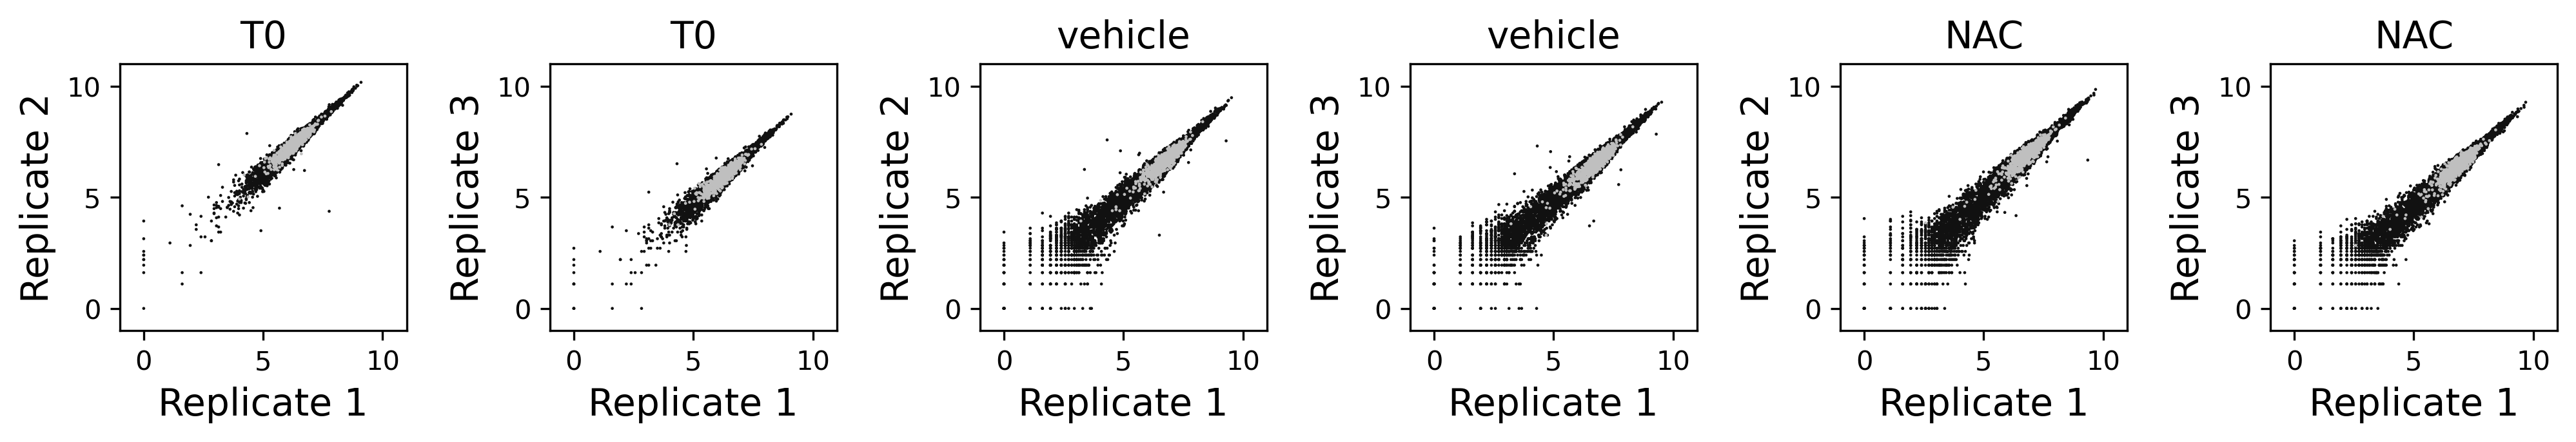

In [27]:
fig, axes = plt.subplots(ncols=6,
                         figsize=(15, 2.3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.9,'bottom':.3}, 
                         # sharey=True
                        )
draw_scatter(screen.adata, 'TO_1_S1','TO_2_S2','T0', axes[0])
draw_scatter(screen.adata, 'TO_1_S1','TO_3_S3','T0', axes[1])

draw_scatter(screen.adata, 'TO_4_S4','TO_5_S5','vehicle', axes[2])
draw_scatter(screen.adata, 'TO_4_S4','TO_6_S6','vehicle', axes[3])

draw_scatter(screen.adata, 'TO_7_S7','TO_8_S8','NAC', axes[4])
draw_scatter(screen.adata, 'TO_7_S7','TO_9_S9','NAC', axes[5])

plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

In [28]:
# screen('results/adata_counts.h5ad.gz')

In [29]:
# adata.var.index = adata.var.target

# adata.var_names_make_unique()

In [30]:
# adata.obs['group'] = adata.obs[['cell line','timepoint','treatment']].apply(' '.join,axis=1)

In [31]:
# ax = sc.pl.violin(adata, ["PRDX2","PRDX3","PRDX4","PRDX5","PRDX6"],
#              layer='log2(x+1)', 
#              groupby='group',rotation=90,size=4,
#                  )

# 
- https://chat.openai.com/share/a37004eb-50bb-491f-be7c-ce4832ec6ce3
- https://chat.openai.com/share/04047284-5811-45bf-acc4-2012c49da931

In [32]:
scp.utils.ann_score_df

<function screenpro.utils.ann_score_df(df_in, up_hit='resistance_hit', down_hit='sensitivity_hit', ctrl_label='non-targeting', threshold=10)>

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def draw_threshold(x, threshold, pseudo_sd):
    return threshold * pseudo_sd * (1 if x > 0 else -1) / abs(x)

def prep_data(df_in,threshold=6):
    df = df_in.copy()

    df = scp.utils.ann_score_df(df,threshold=threshold)

    pseudo_sd = df.loc[df['target'] == 'non-targeting', 'score'].std()

    df['-log10(pvalue)'] = np.log10(df.pvalue) * -1

    return df

def plot_volcano(ax, df_in, threshold=6, up_hit='resistance_hit', down_hit='sensitivity_hit', xlim_l=-5, xlim_r=5, ylim=6):

    df = prep_data(df_in,threshold)
    
    # Scatter plot for each category
    ax.scatter(df.loc[df['label'] == 'target_non_hit', 'score'], df.loc[df['label'] == 'target_non_hit', '-log10(pvalue)'],
               alpha=0.1, s=1, c='black', label='target_non_hit')
    ax.scatter(df.loc[df['label'] == up_hit, 'score'], df.loc[df['label'] == up_hit, '-log10(pvalue)'],
               alpha=0.9, s=1, c='#fcae91', label=up_hit)
    ax.scatter(df.loc[df['label'] == down_hit, 'score'], df.loc[df['label'] == down_hit, '-log10(pvalue)'],
               alpha=0.9, s=1, c='#bdd7e7', label=down_hit)
    ax.scatter(df.loc[df['label'] == 'non-targeting', 'score'], df.loc[df['label'] == 'non-targeting', '-log10(pvalue)'],
               alpha=0.1, s=1, c='gray', label='non-targeting')

    # Set x-axis and y-axis labels
    ax.set_xlabel('phenotype score')
    ax.set_ylabel('-log10(p-value)')

    # Set x-axis limits
    ax.set_xlim(xlim_l, xlim_r)

    # # Set y-axis limits
    # ax.set_ylim(0.1, ylim)

    # Add legend
    ax.legend()

def label_as_black(ax, df_in, label, threshold=6, size=2, size_txt=None, t_x=.5, t_y=-0.1):
    
    df = prep_data(df_in,threshold)
    
    target_data = df[df['target'] == label]

    # Scatter plot for labeled data
    ax.scatter(target_data['score'], target_data['-log10(pvalue)'],
               s=size, linewidth=0.5, edgecolors='black', facecolors='black', label='target')

    if not size_txt:
        size_txt = size * 2
    
    # Annotate the points
    for i, _ in enumerate(target_data['target']):
        txt = target_data['target'].iloc[i]
        ax.annotate(txt, (target_data['score'].iloc[i] + t_x, target_data['-log10(pvalue)'].iloc[i] + t_y),
                    color='black', size=size_txt)

def label_sensitivity_hit(ax, df_in, label, threshold=6, size=2, size_txt=None, t_x=-.5, t_y=-0.1):
    
    df = prep_data(df_in,threshold)
    
    target_data = df[df['target'] == label]

    # Scatter plot for labeled data
    ax.scatter(target_data['score'], target_data['-log10(pvalue)'],
               s=size, linewidth=0.5, edgecolors='black', facecolors='#3182bd', label='target')

    if not size_txt:
        size_txt = size * 2
    
    # Annotate the points
    for i, _ in enumerate(target_data['target']):
        txt = target_data['target'].iloc[i]
        ax.annotate(txt, (target_data['score'].iloc[i] + t_x, target_data['-log10(pvalue)'].iloc[i] + t_y),
                    color='black', size=size_txt)

def label_resistance_hit(ax, df_in, label, threshold=6, size=2, size_txt=None, t_x=.5, t_y=-0.1):

    df = prep_data(df_in,threshold)

    target_data = df[df['target'] == label]

    # Scatter plot for labeled data
    ax.scatter(target_data['score'], target_data['-log10(pvalue)'],
               s=size, linewidth=0.5, edgecolors='black', facecolors='#de2d26', label='target')

    if not size_txt:
        size_txt = size * 2
    
    # Annotate the points
    for i, _ in enumerate(target_data['target']):
        txt = target_data['target'].iloc[i]
        ax.annotate(txt, (target_data['score'].iloc[i] + t_x, target_data['-log10(pvalue)'].iloc[i] + t_y),
                    color='black', size=size_txt)


In [34]:
# import pandas as pd
# from plotnine import ggplot, aes, geom_point, geom_text, xlab, theme, theme_classic, xlim, scale_y_continuous, ylab, stat_function


# def draw_threshold(x, threshold, pseudo_sd):
#     return threshold * pseudo_sd * (1 if x > 0 else -1) / abs(x)


# def plot_volcano(df_in, threshold=6, up_hit='resistance_hit', down_hit='sensitivity_hit', xlim_l=-5, xlim_r=5, ylim=6):
#     df = df_in.copy()
    
#     df = scp.phenoScore.ann_score_df(df,threshold=threshold)
    
#     pseudo_sd = df.loc[df['target'] == 'non-targeting', 'score'].std()
#     df['-log10(pvalue)'] = np.log10(df.pvalue) * -1

#     p = (
#         ggplot(df.dropna(), aes(x='score', y='-log10(pvalue)')) +
#         geom_point(data=df[df['label'] == 'target_non_hit'], alpha=.1,size=1, color=almost_black) +
#         geom_point(data=df[df['label'] == up_hit], alpha=.9,size=1, color='#fcae91') +
#         geom_point(data=df[df['label'] == down_hit], alpha=.9,size=1, color='#bdd7e7') +
#         geom_point(data=df[df['label'] == 'non-targeting'], alpha=.1,size=1, color='gray') +
#         xlab('phenotype score') +
#         theme_classic() +
#         xlim(xlim_l, xlim_r) +
#         scale_y_continuous(limits=(0.1, ylim)) +
#         ylab('-log10(p-value)') +
#         theme(figure_size=(3, 3))  # here you define the plot size
#     )

#     return p


# def label_as_black(p, label, size=2, t_x=5, t_y=-0.1):
#     print(p.data.query(f'target=="{label}"'))
#     return (
#         p +
#         geom_point(data=p.data.query(f'target=="{label}"'), size=size, stroke=0.5, colour="black", fill="black") +
#         geom_text(data=p.data.query(f'target=="{label}"'), mapping=aes(label='target'), color='black', size=size*3, nudge_x=t_x, nudge_y=t_y)
#     )


# def label_sensitivity_hit(p, label, size=2, t_x=-5, t_y=-0.1):
#     return (
#         p +
#         geom_point(data=p.data.query(f'target=="{label}"'), size=size, stroke=0.5, fill="#3182bd") +
#         geom_text(data=p.data.query(f'target=="{label}"'), mapping=aes(label='target'), color='black', size=size*3, nudge_x=t_x, nudge_y=t_y)
#     )


# def label_resistance_hit(p, label, size=2, t_x=5, t_y=-0.1):
#     return (
#         p +
#         geom_point(data=p.data.query(f'target=="{label}"'), size=size, stroke=0.5, fill="#de2d26") +
#         geom_text(data=p.data.query(f'target=="{label}"'), mapping=aes(label='target'), color='black', size=size*3, nudge_x=t_x, nudge_y=t_y)
#     )

### gamma

In [35]:
gamma = screen.phenotypes['compare_reps']['gamma:vehicle_vs_T0'].iloc[:,:3].reset_index(drop=True)

In [36]:
rho = screen.phenotypes['compare_reps']['rho:NAC_vs_vehicle'].iloc[:,:3].reset_index(drop=True)

In [49]:
rho.score.max(),rho.score.min()

(0.344005843712389, -0.3003916208536446)

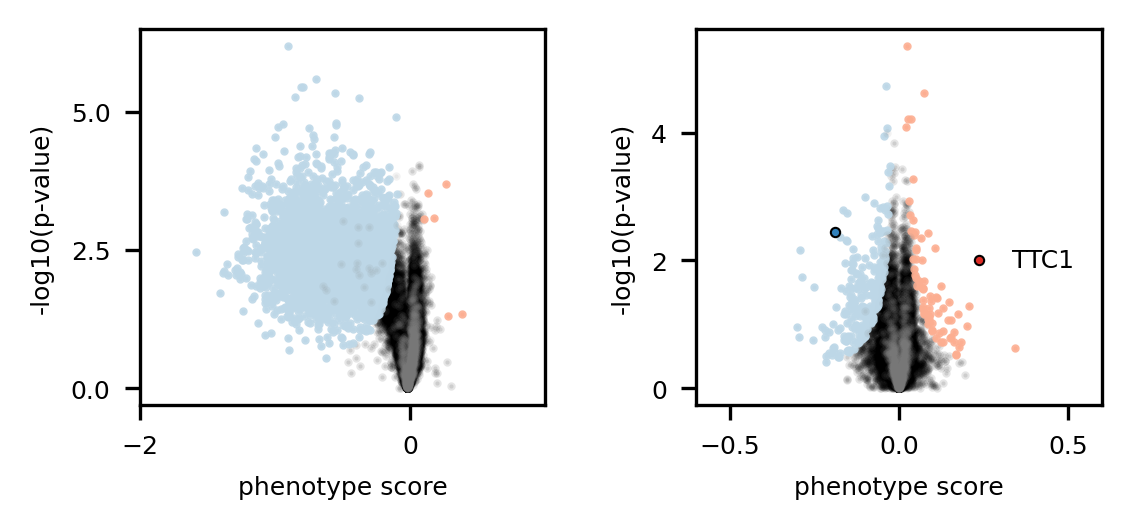

In [51]:
# Create subplots and specify the size
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(4, 2))

plot_volcano(ax1, gamma,threshold=5,xlim_l=-2, xlim_r=1)
ax1.grid(False)
ax1.get_legend().remove()

plot_volcano(ax2, rho,threshold=5,xlim_l=-.6, xlim_r=.6)
label_resistance_hit(ax2,rho,'TTC1',size=5,size_txt=6,t_x=.1)
label_sensitivity_hit(ax2,rho,'CLHC1',size=5,size_txt=6,t_y=.1)

ax2.grid(False)
ax2.get_legend().remove()

for ax in [ax1,ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)

plt.tight_layout()
# Show the plot
plt.show()

In [679]:
# vol.save('NAC_rho_score.pdf')

# 

In [60]:
%reload_ext watermark

In [61]:
%watermark

Last updated: 2023-12-08T16:46:17.940933-08:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [62]:
%watermark --iversions

matplotlib: 3.7.2
pandas    : 2.0.3
anndata   : 0.9.1
numpy     : 1.24.4
screenpro : 0.2.5
scanpy    : 1.9.3



In [63]:
!date

Fri Dec  8 16:46:20 PST 2023
